In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
from torchviz import make_dot

In [2]:
# 读取数据显示数据的前几行
spam=pd.read_csv("data/chap5/spambase.csv")
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [3]:
# 统计垃圾邮件和非垃圾邮件的个数
pd.value_counts(spam.label)



0    2788
1    1813
Name: label, dtype: int64

In [4]:
# 将数据随机切分为训练集以及测试集
X=spam.iloc[:,0:57].values
y=spam.label.values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=123)

In [5]:
# 对数据的前57列特征进行数据标准化处理
scales=MinMaxScaler(feature_range=(0,1))
X_train_s=scales.fit_transform(X_train)
X_test_s=scales.transform(X_test)

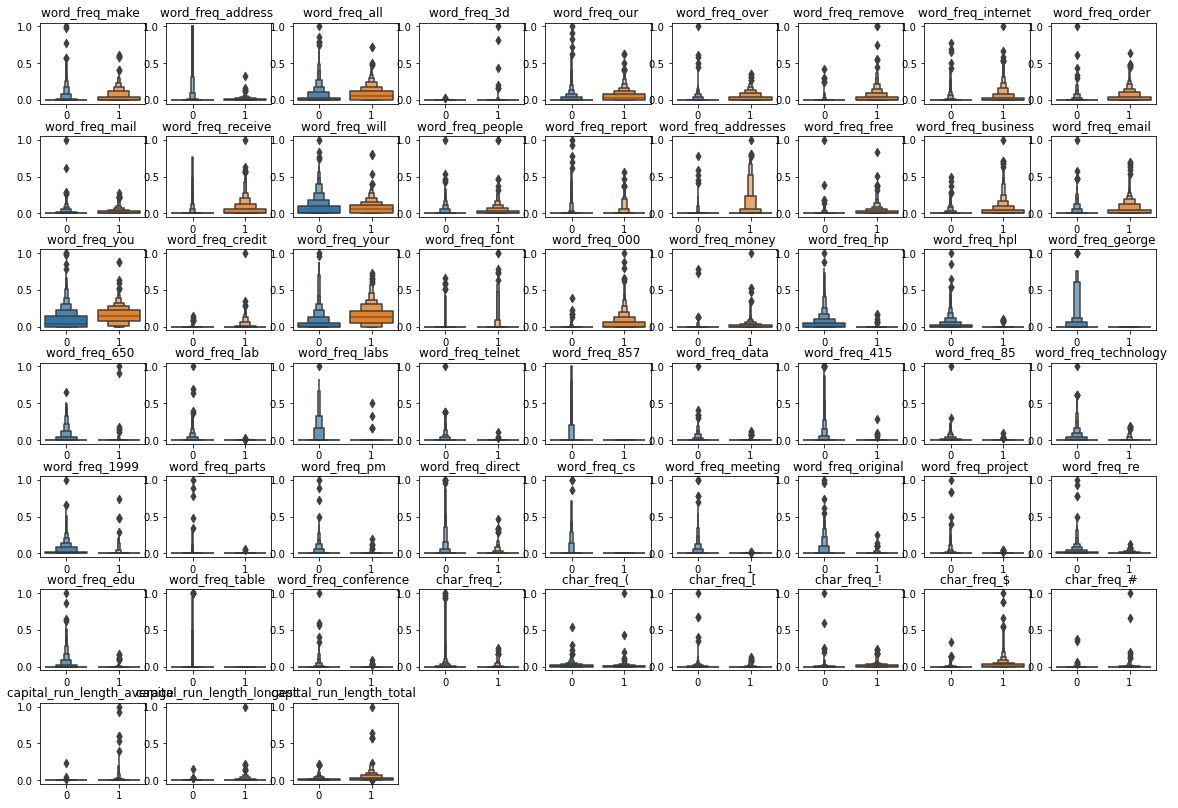

In [6]:
conlname=spam.columns.values[:-1]
plt.figure(figsize=(20,14))
for ii in range(len(conlname)):
    plt.subplot(7,9,ii+1)
    sns.boxenplot(x=y_train,y=X_train_s[:,ii])
    plt.title(conlname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

In [7]:
# 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        # 定义第一个隐藏层
        self.hidden1=nn.Sequential(
            nn.Linear(
                in_features=57,# 第一个隐藏层的输入，数据的特征数
                out_features=30,# 第一个隐藏层的输出，神经元的数量
                bias=True,# 默认会有偏置
            ),
            nn.ReLU() # 激活函数，增加非线性元素的存在，使其结神经网络模型的表达能力更强
        )
        # 定义第二个隐藏层
        self.hidden2=nn.Sequential(
            nn.Linear(30,10),
            nn.ReLU()
        )
        # 分类层
        self.classifica=nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )
    # 定义网络的向前传播路径
    def forward(self,x):
        fc1=self.hidden1(x)
        fc2=self.hidden2(fc1)
        output=self.classifica(fc2)
        # 输出为两个隐藏层和输出层
        return fc1,fc2,output
      

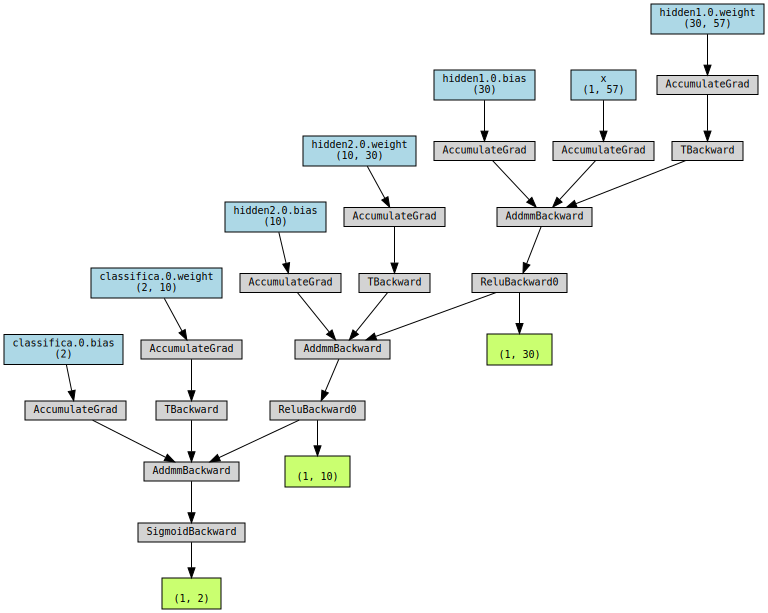

In [8]:
# 输出网络结构
mlpc=MLPclassifica()
# 使用make_dot可视化网络
x=torch.randn(1,57).requires_grad_(True)
y=mlpc(x)
Mymlpcvis=make_dot(y,params=dict(list(mlpc.named_parameters())+[('x',x)]))
Mymlpcvis

In [9]:
# 将数据转化为张量
X_train_nots=torch.from_numpy(X_train.astype(np.float32))
y_train_t=torch.from_numpy(y_train.astype(np.int64))
X_test_nots=torch.from_numpy(X_test.astype(np.float32))
y_test_t=torch.from_numpy(y_test.astype(np.float64))
# 将训练集转化为张量之后，使用TensorDataset将X和Y整理到一起
train_data_nots=Data.TensorDataset(X_train_nots,y_train_t)
# 定义一个数据加载器，将训练数据集进行批处理
train_nots_loader=Data.DataLoader(
    dataset=train_data_nots,# 使用的数据集
    batch_size=64,# 批处理样本大小
    shuffle=True,# 每次迭代之前打乱数据
    num_workers=1,
)

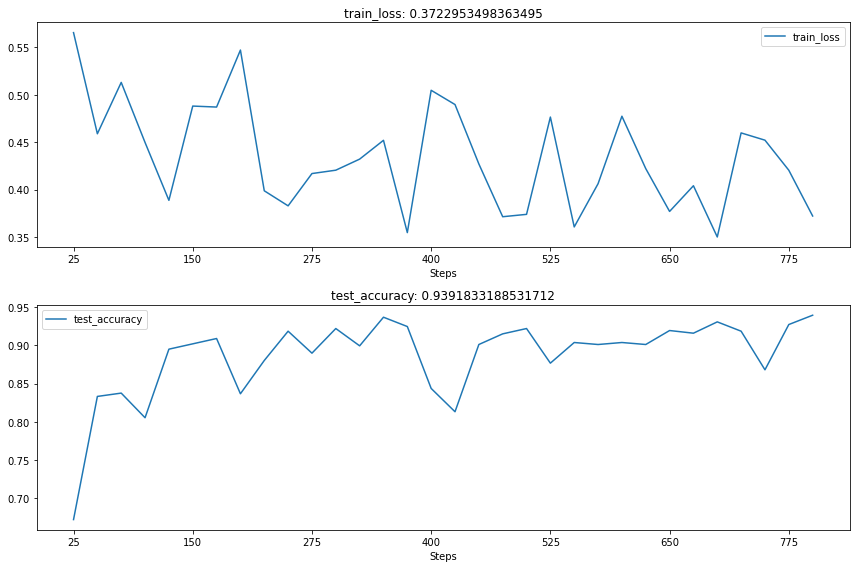

In [10]:
# 定义优化器
optimizer=torch.optim.Adam(mlpc.parameters(),lr=0.01)
loss_func=nn.CrossEntropyLoss() # 二分类损失函数
# 记录训练过程的指标
history1=hl.History()
# 使用Canvas进行可视化
canvas1=hl.Canvas()
print_step=25
# 对模型进行迭代训练，对所有数据训练epoc轮
for epoch in range(15):
    # 对训练数据的加载器进行迭代运算
    for step,(b_x,b_y) in enumerate(train_nots_loader):
        # 计算每一个batch的损失
        _,_,output=mlpc(b_x)# MLP在训练batch上的输出
        train_loss=loss_func(output,b_y) # 二分类交叉熵损失函数
        optimizer.zero_grad()# 每个迭代步的梯度初始化为0
        train_loss.backward()# 损失的后向传播，计算梯度
        optimizer.step()# 使用梯度进行优化
        niter=epoch*len(train_nots_loader)+step+1
        # 计算每经过print_step次迭代后的输出
        if niter%print_step==0:
            _,_,output=mlpc(X_test_nots)
            _,pre_lab=torch.max(output,1)
            test_accuracy=accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch,损失和精度
            history1.log(niter,train_loss=train_loss,
            test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数以及精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])


In [11]:
# 将数据转化为张量
X_train_t=torch.from_numpy(X_train_s.astype(np.float32))
y_train_t=torch.from_numpy(y_train.astype(np.int64))
X_test_t=torch.from_numpy(X_test_s.astype(np.float32))
y_test_t=torch.from_numpy(y_test.astype(np.float64))
# 将训练集转化为张量之后，使用TensorDataset将X和Y整理到一起
train_data=Data.TensorDataset(X_train_t,y_train_t)
# 定义一个数据加载器，将训练数据集进行批处理
train_loader=Data.DataLoader(
    dataset=train_data,# 使用的数据集
    batch_size=64,# 批处理样本大小
    shuffle=True,# 每次迭代之前打乱数据
    num_workers=1,
)

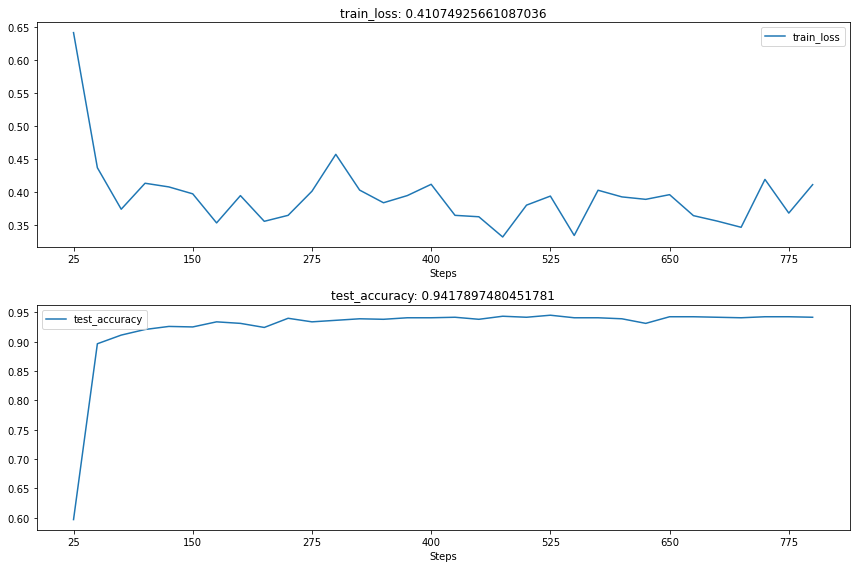

In [12]:
# 定义优化器
optimizer=torch.optim.Adam(mlpc.parameters(),lr=0.01)
loss_func=nn.CrossEntropyLoss() # 二分类损失函数
# 记录训练过程的指标
history1=hl.History()
# 使用Canvas进行可视化
canvas1=hl.Canvas()
print_step=25
# 对模型进行迭代训练，对所有数据训练epoc轮
for epoch in range(15):
    # 对训练数据的加载器进行迭代运算
    for step,(b_x,b_y) in enumerate(train_loader):
        # 计算每一个batch的损失
        _,_,output=mlpc(b_x)# MLP在训练batch上的输出
        train_loss=loss_func(output,b_y) # 二分类交叉熵损失函数
        optimizer.zero_grad()# 每个迭代步的梯度初始化为0
        train_loss.backward()# 损失的后向传播，计算梯度
        optimizer.step()# 使用梯度进行优化
        niter=epoch*len(train_loader)+step+1
        # 计算每经过print_step次迭代后的输出
        if niter%print_step==0:
            _,_,output=mlpc(X_test_t)
            _,pre_lab=torch.max(output,1)
            test_accuracy=accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch,损失和精度
            history1.log(niter,train_loss=train_loss,
            test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数以及精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])


In [13]:
# 计算模型在测试集上的最终精度
_,_,output=mlpc(X_test_t)
_,pre_lab=torch.max(output,1)
test_accuracy=accuracy_score(y_test_t,pre_lab)
print("test_accuracy：",test_accuracy)


test_accuracy： 0.9400521285838401


In [14]:
# 计算最终模型在测试集上的第二个隐藏层的输出
_,test_fc2,_=mlpc(X_test_t)
print("test_fc_2.shape:",test_fc2.shape)

test_fc_2.shape: torch.Size([1151, 10])


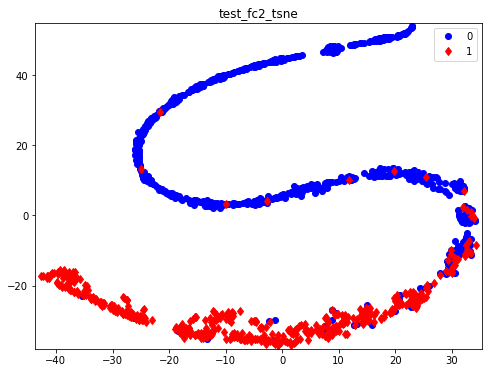

In [15]:
# 对输出进行降维并可视化
test_fc2_tsne=TSNE(n_components=2).fit_transform(test_fc2.data.numpy())
# 将特征进行可视化
plt.figure(figsize=(8,6))
# 可视化前课时坐标系的取值范围
plt.xlim([min(test_fc2_tsne[:,0]-1),max(test_fc2_tsne[:,0])+1])
plt.ylim([min(test_fc2_tsne[:,1]-1),max(test_fc2_tsne[:,1])+1])
plt.plot(test_fc2_tsne[y_test==0,0],test_fc2_tsne[y_test==0,1],"bo",label="0")
plt.plot(test_fc2_tsne[y_test==1,0],test_fc2_tsne[y_test==1,1],"rd",label="1")
plt.legend()
plt.title("test_fc2_tsne")
plt.show()

In [16]:
# 定义一个辅助函数，来获取指定层名称的特征
activation={} # 保留不同层的输出
def get_activation(name):
    def hook(model,input,output):
        activation[name]=output.detach()
    return hook


In [18]:
# 全连接层网络获取分类层的输出
mlpc.classifica.register_forward_hook(get_activation("classifica"))
_,_,_=mlpc(X_test_t)
classifica=activation["classifica"].data.numpy()
print("classifica.shape:",classifica.shape)


classifica.shape: (1151, 2)


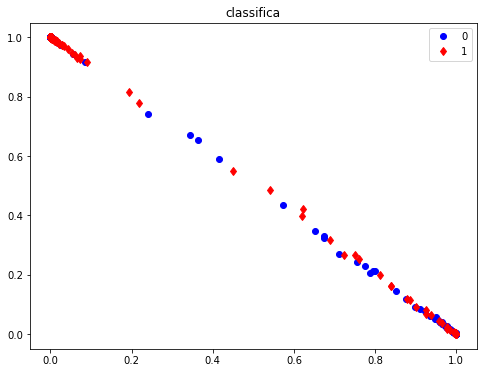

In [19]:
# 将特征进行可视化
plt.figure(figsize=(8,6))
# 可视化每类的散点图
plt.plot(classifica[y_test==0,0],classifica[y_test==0,1],"bo",label="0")
plt.plot(classifica[y_test==1,0],classifica[y_test==1,1],"rd",label="1")
plt.legend()
plt.title("classifica")
plt.show()